# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

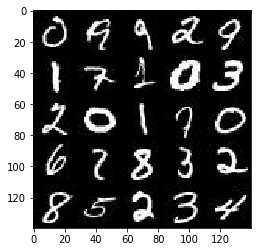

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

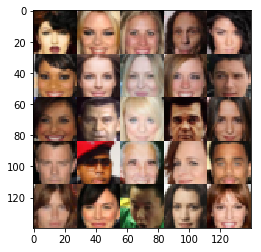

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="Input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="Input_z")
    learning_rate = tf.placeholder(tf.float32)

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [32]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #drop = 0.5
    with tf.variable_scope("discriminator", reuse=reuse):
        #Input to discriminator is 28x28xChannels
        disc = tf.layers.conv2d(images, 128, 5, strides=1, padding='same')
        disc = tf.maximum(alpha*disc, disc)
        
        #shape=28x28x64
        disc = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        disc = tf.layers.batch_normalization(disc, training=True)
        #disc = tf.nn.dropout(disc, drop)
        disc = tf.maximum(alpha*disc, disc)
        
        #shape=14x14x128
        disc = tf.layers.conv2d(disc, 32, 5, strides=2, padding='same')
        disc = tf.layers.batch_normalization(disc, training=True)
        #disc = tf.nn.dropout(disc, drop)
        disc = tf.maximum(alpha*disc, disc)
        
        #Flattening
        flat = tf.reshape(disc, (-1, 4*4*32))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #drop = 0.5
    reuse = True if is_train==False else False
    with tf.variable_scope("generator", reuse=reuse):
        #gen = tf.nn.dropout(tf.layers.dense(z, 7*7*512), drop)
        gen = tf.layers.dense(z, 7*7*128)
        gen = tf.reshape(gen, (-1,7,7,128))
        gen = tf.layers.batch_normalization(gen, training=is_train)
        #gen = tf.nn.dropout(gen, drop)
        gen = tf.maximum(alpha*gen, gen)
        #Input is 7x7x512
        gen = tf.layers.conv2d_transpose(gen, 64, 5, strides=2, padding='same')
        gen = tf.layers.batch_normalization(gen, training=is_train)
        #gen = tf.nn.dropout(gen, drop)
        gen = tf.maximum(alpha*gen, gen)
        #Now 14x14x256
        gen = tf.layers.conv2d_transpose(gen, 32, 5, strides=2, padding='same')
        gen = tf.layers.batch_normalization(gen, training=is_train)
        #gen = tf.nn.dropout(gen, drop)
        gen = tf.maximum(alpha*gen, gen)
        #Now 28x28x128        
        
        logits = tf.layers.conv2d_transpose(gen, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=tf.ones_like(disc_model_real)))
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.ones_like(disc_model_fake)))
    
    disc_total_loss = disc_loss_real + disc_loss_fake
    
    return (disc_total_loss, gen_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
    return (disc_train_opt, gen_train_opt)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    channels = 3 if data_image_mode == 'RGB' else 1
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0    
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                #For printing and sampling purposes
                step+=1
                #Random noise for z
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Optimizers
                #Discriminator
                _, train_loss_d = sess.run([d_opt,d_loss], feed_dict={input_real : batch_images,
                                               input_z : batch_z,
                                               lr : learning_rate})
                #Generator
                _, train_loss_g = sess.run([g_opt,g_loss], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})
                _ = sess.run([g_opt], feed_dict={input_z : batch_z,
                                               input_real : batch_images,
                                               lr : learning_rate})
                if(step%25 == 0):
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if(step%100 == 0):
                    show_generator_output(sess, 10, input_z, channels, data_image_mode)                                                                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 0.9928
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 1.1150
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 0.8460
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.8447


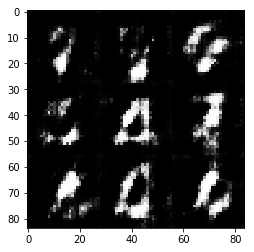

Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 0.8481
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.3037... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.7991


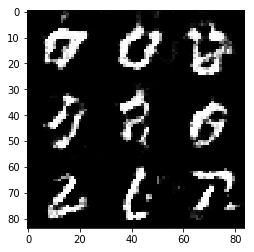

Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.7689
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.7490
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.7633


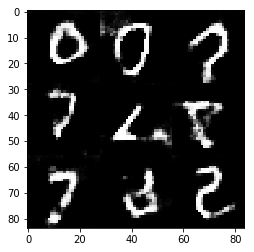

Epoch 1/2... Discriminator Loss: 1.3437... Generator Loss: 0.7696
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 0.7904
Epoch 1/2... Discriminator Loss: 1.3492... Generator Loss: 0.7756
Epoch 1/2... Discriminator Loss: 1.3507... Generator Loss: 0.7625


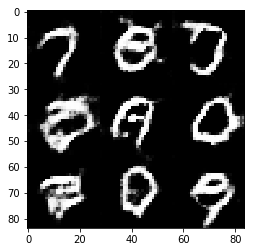

Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 0.7674


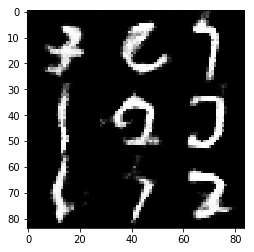

Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 0.7676
Epoch 1/2... Discriminator Loss: 1.3044... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.7559


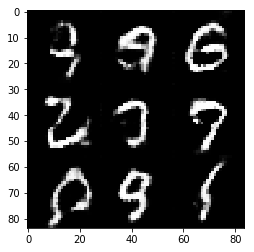

Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 0.8105
Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 0.7469
Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 0.8016


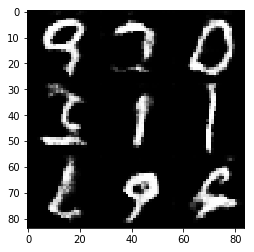

Epoch 1/2... Discriminator Loss: 1.3400... Generator Loss: 0.7407
Epoch 1/2... Discriminator Loss: 1.3138... Generator Loss: 0.8605
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.8529
Epoch 1/2... Discriminator Loss: 1.2869... Generator Loss: 0.7913


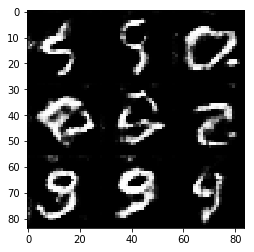

Epoch 1/2... Discriminator Loss: 1.2964... Generator Loss: 0.7951
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.8440


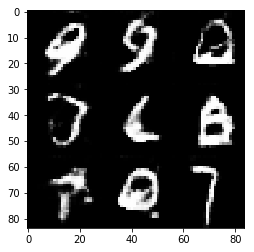

Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 0.8250
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 0.7860
Epoch 1/2... Discriminator Loss: 1.3205... Generator Loss: 0.8656


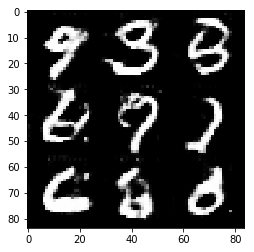

Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 0.8383
Epoch 1/2... Discriminator Loss: 1.3137... Generator Loss: 0.8038
Epoch 1/2... Discriminator Loss: 1.2902... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 0.8062


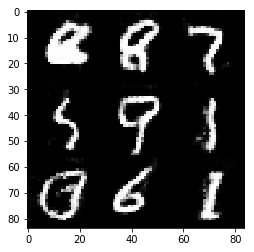

Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 0.7714
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.8046


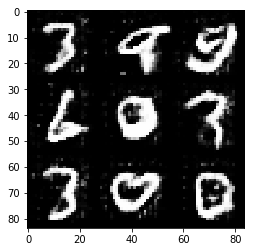

Epoch 1/2... Discriminator Loss: 1.3396... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.4261... Generator Loss: 0.7794
Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 0.7801


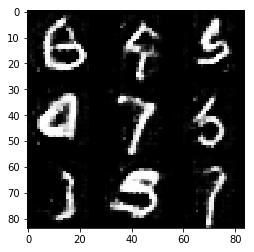

Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.8632
Epoch 1/2... Discriminator Loss: 1.3224... Generator Loss: 0.7750
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.8140
Epoch 1/2... Discriminator Loss: 1.3299... Generator Loss: 0.8380


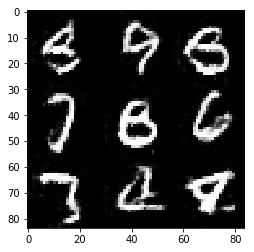

Epoch 1/2... Discriminator Loss: 1.3492... Generator Loss: 0.7951
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 0.7606


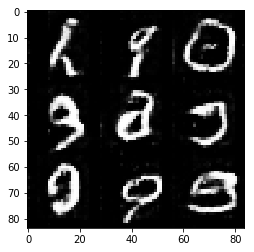

Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 1.3504... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.7631


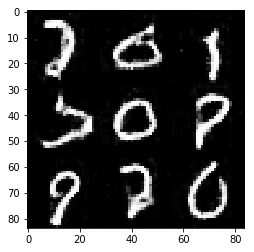

Epoch 1/2... Discriminator Loss: 1.3313... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.3433... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.7746
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.7711


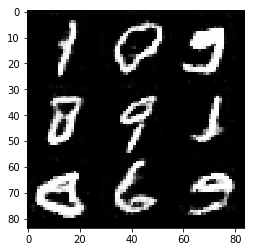

Epoch 1/2... Discriminator Loss: 1.3436... Generator Loss: 0.7520
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.7785
Epoch 1/2... Discriminator Loss: 1.3400... Generator Loss: 0.7820
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.7897


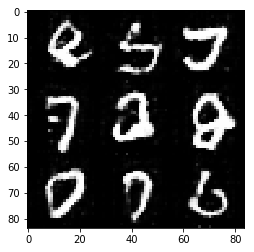

Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.7671
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 0.7620
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.8156


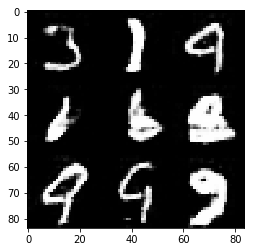

Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.7835
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.7919
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 0.8057


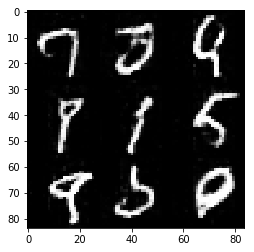

Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.7891
Epoch 2/2... Discriminator Loss: 1.3373... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.7925


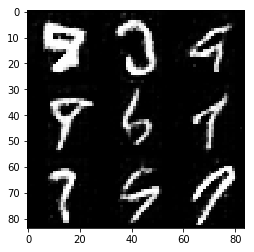

Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.7511
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.8557
Epoch 2/2... Discriminator Loss: 1.3486... Generator Loss: 0.7501


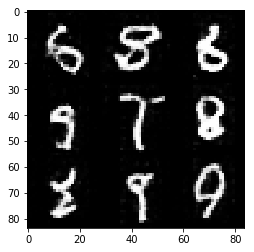

Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 0.7804
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.8254
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 0.7821
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.7781


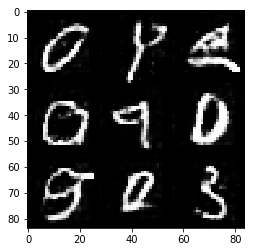

Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.7766
Epoch 2/2... Discriminator Loss: 1.3217... Generator Loss: 0.8103
Epoch 2/2... Discriminator Loss: 1.3655... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 0.7556


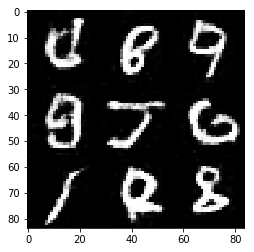

Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 0.8093
Epoch 2/2... Discriminator Loss: 1.4348... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 1.3297... Generator Loss: 0.7846


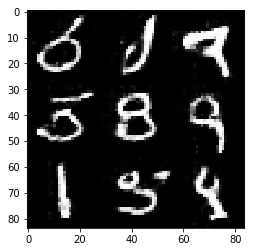

Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.7963
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.7840
Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 0.7893


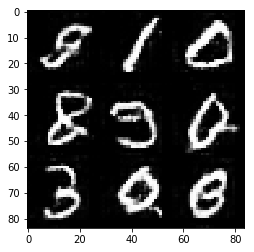

Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.7241
Epoch 2/2... Discriminator Loss: 1.3564... Generator Loss: 0.7725


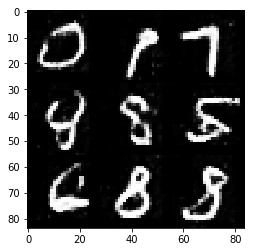

Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.7569
Epoch 2/2... Discriminator Loss: 1.3305... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 1.3002... Generator Loss: 0.7962


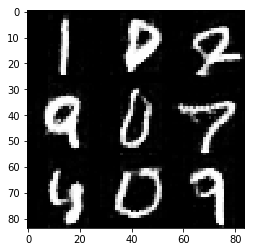

Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.7395
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.7808
Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 0.8004


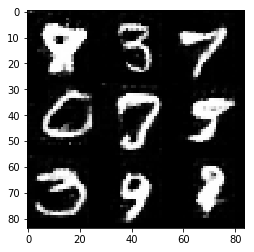

Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.7469
Epoch 2/2... Discriminator Loss: 1.3296... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.7922
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.7624


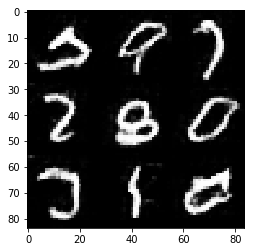

Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.8133
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 0.7862


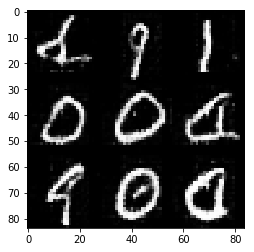

Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 0.7528
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 1.3239... Generator Loss: 0.8027


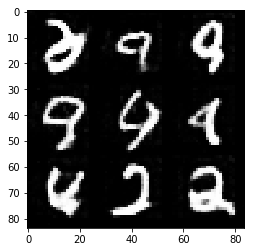

Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 0.7595
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.7756
Epoch 2/2... Discriminator Loss: 1.3666... Generator Loss: 0.7523
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.7955


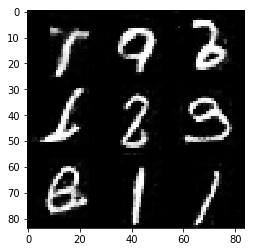

Epoch 2/2... Discriminator Loss: 1.3457... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 1.2893... Generator Loss: 0.8296
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.8000
Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 0.7713


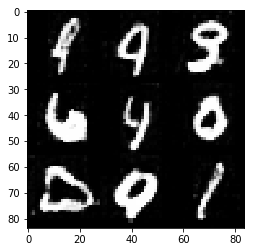

Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.3595... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 0.7832
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.8274


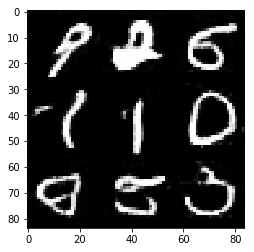

Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 0.7987
Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 0.7629
Epoch 2/2... Discriminator Loss: 1.3230... Generator Loss: 0.8063
Epoch 2/2... Discriminator Loss: 1.3263... Generator Loss: 0.8308


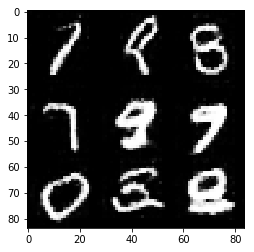

Epoch 2/2... Discriminator Loss: 1.3373... Generator Loss: 0.8003
Epoch 2/2... Discriminator Loss: 1.3219... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 1.3040... Generator Loss: 0.8261
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.7677


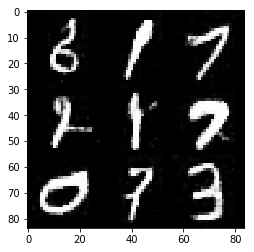

Epoch 2/2... Discriminator Loss: 1.3474... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.7822


In [34]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.